# Version A   - Learns the model with the training data once and predicts prices for several days
- load data
- split data in training and test
- training datased scaling and reshaping
- LSTM run 
- losss & accuracy displays
- get and reshape testing dataset
- forecast
- plot 
- Saving/loading model
- Results

In [372]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import yfinance as yf
from pandas_datareader import data as pdr

from keras.models import load_model
import tensorflow as tf


In [374]:
yf.pdr_override()
data = pdr.get_data_yahoo("EURUSD=X", start="2015-07-10",end="2021-06-15").reset_index()
#data=data[:-2] #keeping info to the last day
data

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,1.106305,1.122000,1.105620,1.106305,1.106305,0
1,2015-07-13,1.112904,1.119759,1.100770,1.112904,1.112904,0
2,2015-07-14,1.098515,1.107400,1.096850,1.099046,1.099046,0
3,2015-07-15,1.100897,1.104000,1.093610,1.100800,1.100800,0
4,2015-07-16,1.093888,1.095000,1.085940,1.094355,1.094355,0
...,...,...,...,...,...,...,...
1520,2021-06-09,1.217182,1.221899,1.217182,1.217285,1.217285,0
1521,2021-06-10,1.217730,1.219215,1.214535,1.218200,1.218200,0
1522,2021-06-11,1.217315,1.219500,1.209500,1.217256,1.217256,0
1523,2021-06-14,1.211079,1.213151,1.209526,1.211020,1.211020,0


In [377]:
split_date='2021-05-31'
split_index=data.index[data.Date==split_date].tolist()[0]
print(split_index)

training_set = data.iloc[:split_index+1, 4:5].values
test_set  = data.iloc[split_index+1:, 4:5].values
print(training_set.shape, test_set.shape)

1513
(1514, 1) (11, 1)


In [380]:
# Let’s build the input features with time lag of 1 day (lag 1):

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

window_size = 30  # number of time steps to look back

In [382]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
print(window_size, training_set_scaled.shape[0])
for i in range(window_size, training_set_scaled.shape[0]):
    #print(f'{i-window_size}:{i},0')
    X_train.append(training_set_scaled[i-window_size:i, 0])
    y_train.append(training_set_scaled[i, 0])
    #print(X_train)
    #print(y_train)
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
#X_train

30 1514
(1484, 30)
(1484, 30, 1)


In [383]:
from keras.backend import clear_session
clear_session()

In [384]:
units_n = 50
epochs_n = 300  #set
bs_n = 32  #set
seq = 10

In [385]:
tf.random.set_seed(123)

In [386]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = units_n, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = units_n, return_sequences = True))
model.add(LSTM(units = units_n, return_sequences = False))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, epochs = epochs_n, batch_size = bs_n)

Epoch 1/300
47/47 [==============================] - 6s 34ms/step - loss: 0.0611 - accuracy: 4.7216e-04
Epoch 2/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0047 - accuracy: 8.0467e-04
Epoch 3/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0043 - accuracy: 1.1340e-04
Epoch 4/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0038 - accuracy: 0.0013
Epoch 5/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0036 - accuracy: 0.0011
Epoch 6/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0032 - accuracy: 0.0017
Epoch 7/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0034 - accuracy: 6.8636e-04
Epoch 8/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0033 - accuracy: 9.7484e-04
Epoch 9/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0030 - accuracy: 6.7265e-04
Epoch 10/300
47/47 [==============================] - 2s 34ms/step - loss: 0

In [387]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


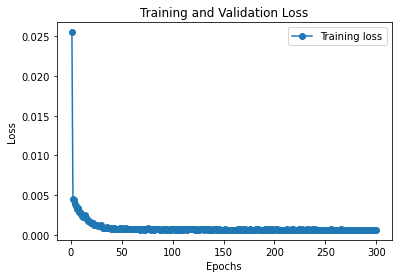

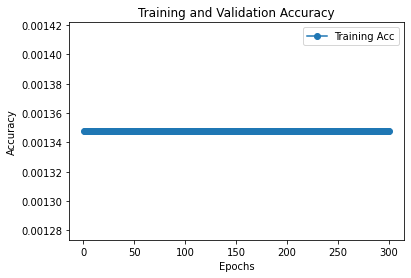

In [388]:
loss = history.history['loss']
epochs = range (1, len(loss)+1)
plt.plot(epochs, loss, marker='o', label='Training loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
plt.plot(epochs, acc, marker='o', label='Training Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [389]:
#split_date='2021-05-31'
split_index=data.index[data.Date==split_date].tolist()[0]
print(split_index)

training_set = data.iloc[:split_index+1, 4:5].values
test_set  = data.iloc[split_index+1:, 4:5].values
print(training_set.shape, test_set.shape)

1513
(1514, 1) (11, 1)


In [390]:
split_date

'2021-05-31'

In [392]:
# Getting the predicted stock price of 2017
dataset_train = data.iloc[:split_index+1, 4:5]
dataset_test = data.iloc[split_index+1:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(data.iloc[:split_index+1, 4:5].shape, dataset_train.shape, dataset_test.shape, dataset_total.shape)

print(len(dataset_total),len(dataset_test),window_size)
print(f'{len(dataset_total) - len(dataset_test) - window_size}:')
inputs = dataset_total[len(dataset_total) - len(dataset_test) - window_size:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print('\n',inputs.shape)


(1514, 1) (1514, 1) (11, 1) (1525, 1)
1525 11 30
1484:

 (41, 1)


In [393]:
X_test = []
for i in range(window_size, len(inputs)):
    X_test.append(inputs[i-window_size:i, 0])
    #print(i, X_test)
X_test = np.array(X_test)
#print(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#print(X_test)
print(X_test.shape)

(11, 30, 1)


In [396]:
# Make Predictions using the test set

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price 

array([[1.2197508],
       [1.2243677],
       [1.2222568],
       [1.2219919],
       [1.2139701],
       [1.2183974],
       [1.2199126],
       [1.2184862],
       [1.2188898],
       [1.2177968],
       [1.2118464]], dtype=float32)

In [397]:
#GET THE ROOT MEAN SQUARED
rmse=np.sqrt(np.mean((predicted_stock_price - dataset_test)**2))
rmse

Close    0.003829
dtype: float64

In [398]:
# prepare  data for plotting
plot_train=data[:len(dataset_train)].copy()
plot_train.Date=pd.to_datetime(plot_train.Date)
plot_valid=data[len(dataset_train):].copy()
plot_valid['Predictions']=predicted_stock_price
plot_valid.Date=pd.to_datetime(plot_valid.Date)


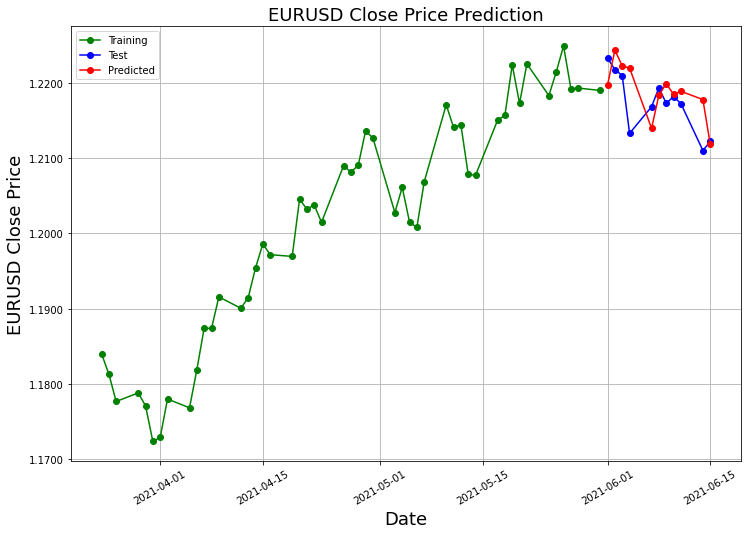

In [432]:
# plotting
import matplotlib.ticker as ticker

days_to_display=49

plt.figure(figsize=(12,8))
plt.plot(plot_train.Date[-days_to_display:],plot_train.Close[-days_to_display:], color = 'green', label = 'Training', marker='o')
plt.plot(plot_valid.Date, plot_valid.Close, color = 'blue', label = 'Test', marker='o')
plt.plot(plot_valid.Date, plot_valid.Predictions, color = 'red', label = 'Predicted', marker='o')
plt.title('EURUSD Close Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('EURUSD Close Price', fontsize=18)


plt.xticks(rotation=30)
ax=plt.gca()
formatter = ticker.FormatStrFormatter('%1.4f')
ax.yaxis.set_major_formatter(formatter)

plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Saving and loading models

In [401]:
#!mkdir -p saved_models

In [402]:
#from keras.models import load_model

In [403]:

name=str('model')+'_seq'+str(seq)+'_u'+str(units_n)+'_e'+str(epochs_n)+'_bs'+str(bs_n)+'_w'+str(window_size)
name

'model_seq10_u50_e300_bs32_w30'

In [404]:
# saves the architecture of the model, the weights, the training config (loss, optimizer)
# and the state of the optimizer so you can resume training where you left off

model.save('saved_models/'+name+'_h5',save_format='h5')

In [405]:
loaded_model=load_model('saved_models/'+name+'_h5')
#loaded_model.summary()

In [406]:
predicted_stock_price = loaded_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[1.2197508],
       [1.2243677],
       [1.2222568],
       [1.2219919],
       [1.2139701],
       [1.2183974],
       [1.2199126],
       [1.2184862],
       [1.2188898],
       [1.2177968],
       [1.2118464]], dtype=float32)

# Results

In [433]:
count=0
data1=plot_valid[['Date','Close','Predictions']].copy()    #copy of the test_forecasted data
data1=data1.set_index('Date')
data1['action']=np.nan
data1['Close_previous_day']=np.nan
data1['pips']=np.nan
pips_buy=[]
pips_sell=[]

for i in range(0,data1.shape[0]):      
    #print(count)
    current_day_price=data1.iloc[i,1]               # todays predicted price
    if count==0:       
        previous_day_price=plot_train[-1:].Close.values[0]    # yesterdays close price from training data last day
        data1.iloc[i,3] = previous_day_price
    else:
        previous_day_price = data1.iloc[i-1,1]        # yesterdays predicted price 
        data1.iloc[i,3] = data1.iloc[i-1,0]            # yesterdays close price  from test data
    count = count + 1
    #print(i, current_day_price, previous_day_price) 
    
    #diff = current_day_price-previous_day_price
    if current_day_price > previous_day_price:
        data1.iloc[i,2] = 'buy'
        diff_pips = data1.iloc[i,0] - data1.iloc[i,3]
    else:
        data1.iloc[i,2] = 'sale'
        diff_pips = data1.iloc[i,3] - data1.iloc[i,0]
    data1.iloc[i,4] = diff_pips
        


data1=data1.reindex(columns=['Predictions','Close_previous_day','action','Close','pips']).reset_index()
data1



,Date,Predictions,Close_previous_day,action,Close,pips
0,2021-06-01,1.219751,1.219007,buy,1.223287,0.004280
1,2021-06-02,1.224368,1.223287,buy,1.221777,-0.001510
2,2021-06-03,1.222257,1.221777,sale,1.220986,0.000791
3,2021-06-04,1.221992,1.220986,sale,1.213301,0.007686
4,2021-06-07,1.213970,1.213301,sale,1.216841,-0.003540
5,2021-06-08,1.218397,1.216841,buy,1.219363,0.002522
6,2021-06-09,1.219913,1.219363,buy,1.217285,-0.002078
7,2021-06-10,1.218486,1.217285,sale,1.218200,-0.000915
8,2021-06-11,1.218890,1.218200,buy,1.217256,-0.000945
9,2021-06-14,1.217797,1.217256,sale,1.211020,0.006235


In [434]:
data1.groupby('action').sum().pips

action
buy     0.002270
sale    0.009053
Name: pips, dtype: float64

In [435]:
accuracy=data1.pips[data1.pips>0].count()/len(data1.pips)
accuracy*100

45.45454545454545

In [436]:
rmse

Close    0.003829
dtype: float64

# Retrain everyday the model

# Version B   - Learns the model with a rolling (daily) training dataset and predicts price only once
- load data
- split data in training and test
- training datased scaling and reshaping
- LSTM run 
- losss & accuracy displays
- get and reshape testing dataset
- forecast
- plot 
- Saving/loading model
- Results

In [360]:
def get_data(day):
    end_date=day
    # get data to the date
    yf.pdr_override()
    start_date="2015-07-10"
    data_new = pdr.get_data_yahoo("EURUSD=X", start=start_date,end=end_date).reset_index()
    #data_new.tail(15)
    print(' ***** get data finished *****\n ')
    return data_new

In [361]:
def prep_data(data_new1, window_size):
    test_index = len(data_new1) - window_size - 1
    training_new = data_new1.iloc[:-1, 4:5].values
    test_new  = data_new1.iloc[test_index:, 4:5].values
    #print(training_new.shape,test_new.shape )

    # Feature Scaling
    sc_new = MinMaxScaler(feature_range = (0, 1))
    training_set_scale = sc_new.fit_transform(training_new)
    
    # Creating a data structure with 30 time-steps and 1 output
    X_train_new = []
    y_train_new = []
    for i in range(window_size, training_set_scale.shape[0]):
        X_train_new.append(training_set_scale[i-window_size:i, 0])
        y_train_new.append(training_set_scale[i, 0])
    X_train_new, y_train_new = np.array(X_train_new), np.array(y_train_new)
    X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], X_train_new.shape[1], 1))
    #print(X_train_new.shape)
    print(' ***** prep data finished ***** \n')
    return X_train_new, y_train_new, test_new, sc_new

In [362]:
def display_loss(history_new):
    loss = history_new.history['loss']
    epochs = range (1, len(loss)+1)
    plt.plot(epochs, loss, marker='o', label='Training loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(' ***** display loss finished *****\n')

In [363]:
def get_quote(data_new1, sc_new, window_size):
    test_index = len(data_new1) - window_size - 1
    test_new  = data_new1.iloc[test_index:, 4:5].values
    inputs_new = sc_new.transform(test_new)
    #print('\n',inputs_new.shape)

    X_test_new = []
    for i in range(window_size, len(inputs_new)):
        X_test_new.append(inputs_new[i-window_size:i, 0])
    X_test_new = np.array(X_test_new)
    X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], 1))
    #print(X_test_new.shape)
    print(' ***** get quote finished *****\n')
    return X_test_new

In [364]:
def get_quote_prep(data_new1,predicted_stock_price_new):
    plot_train_new=data_new1[:len(data_new1)-1][['Date','Close']].copy()
    plot_valid_new=data_new1[-1:][['Date','Close']].copy()
    plot_valid_new['Predictions']=predicted_stock_price_new
    #print(plot_valid_new)
    print(' ***** get quote prep finished *****\n')
    return plot_train_new, plot_valid_new
    


In [365]:
def get_results(plot_train_new1, plot_valid_new1):
    data_result=plot_valid_new1.copy()    #copy of the test_forecasted data
    data_result=data_result.set_index('Date')   # becomes index
    data_result['Close_previous_day']=np.nan    # becomes column 2
    data_result['action']=np.nan                # becomes column 3
    data_result['pips']=np.nan                  # becomes column 4
    pips_new_buy=[]
    pips_new_sell=[]

    for i in range(0,data_result.shape[0]):      
        predicted_price=data_result.iloc[i,1]               # todays predicted price     
        previous_day_real_price=plot_train_new1[-1:].Close.values[0]    # yesterdays close price from training data last day
        #print(previous_day_real_price)
        data_result.iloc[i,2] = previous_day_real_price


        if predicted_price > previous_day_real_price:
            data_result.iloc[i,3] = 'buy'
            diff_pips = data_result.iloc[i,0] - data_result.iloc[i,2]
        else:
            data_result.iloc[i,3] = 'sale'
            diff_pips = data_result.iloc[i,2] - data_result.iloc[i,0]
        data_result.iloc[i,4] = diff_pips


    data_result=data_result.reindex(columns=['Predictions','Close_previous_day','action','Close','pips'])
    #print(data_result)
    print(' ***** get results finished *****\n')
    return data_result


In [366]:
def append_result(data_result1):
    df=data_result1.reset_index()
    #print(df)
    print(' ***** append table finished *****\n')
    return df

In [367]:
def display_graph(plot_train_new1, plot_valid_new1, days_to_display):
    plt.figure(figsize=(12,8))
    plt.plot(plot_train_new1.Date[-days_to_display:],plot_train_new1.Close[-days_to_display:], color = 'green', label = 'Training', marker='o')
    plt.plot(plot_valid_new1.Date, plot_valid_new1.Close, color = 'blue', label = 'Test', marker='o')
    plt.plot(plot_valid_new1.Date, plot_valid_new1.Predictions, color = 'red', label = 'Predicted', marker='o')
    plt.title('EURUSD Close Price Prediction', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('EURUSD Close Price', fontsize=18)


    plt.xticks(rotation=30)
    ax=plt.gca()
    formatter = ticker.FormatStrFormatter('%1.4f')
    ax.yaxis.set_major_formatter(formatter)

    plt.legend()
    plt.grid(True)
    plt.show()
    print(' ***** display graph finished *****\n')

In [369]:

list_of_dates_to_analyze=["2021-06-01","2021-06-02","2021-06-03","2021-06-04","2021-06-07","2021-06-08","2021-06-09",
                          "2021-06-10","2021-06-11","2021-06-14","2021-06-15"]


[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 37ms/step - loss: 0.0611 - accuracy: 4.7216e-04
Epoch 2/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0047 - accuracy: 8.0467e-04
Epoch 3/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0043 - accuracy: 1.1340e-04
Epoch 4/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0038 - accuracy: 0.0013
Epoch 5/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0036 - accuracy: 0.0011
Epoch 6/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0032 - accuracy: 0.0017
Epoch 7/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0034 - accuracy: 6.8636e-04
Epoch 8/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0033 - accuracy: 9.7484e-04
Epoch 9/300
47/47 [=========================

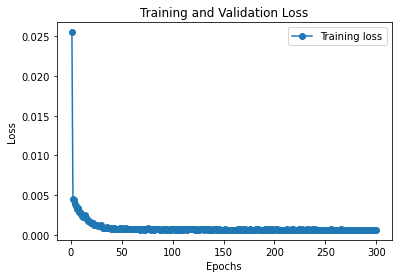

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 37ms/step - loss: 0.0789 - accuracy: 2.4153e-04
Epoch 2/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0047 - accuracy: 0.0020
Epoch 3/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0044 - accuracy: 9.6738e-04
Epoch 4/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0040 - accuracy: 0.0015
Epoch 5/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0036 - accuracy: 8.1183e-04
Epoch 6/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0037 - accuracy: 0.0034
Epoch 7/300
47/47 [==============================] - 2s 37ms/step - loss: 

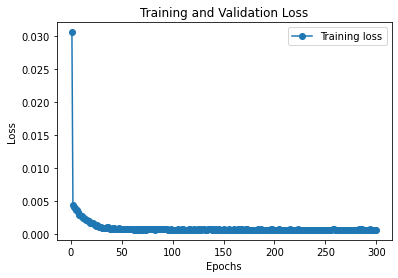

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 35ms/step - loss: 0.0680 - accuracy: 6.1326e-04
Epoch 2/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0048 - accuracy: 0.0011
Epoch 3/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0043 - accuracy: 5.8687e-04
Epoch 4/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0042 - accuracy: 6.3487e-04
Epoch 5/300
47/47 [==============================] - 2s 33ms/step - loss: 0.0041 - accuracy: 0.0011
Epoch 6/300
47/47 [==============================] - 2s 34ms/step - loss: 0.0035 - accuracy: 2.2240e-04
Epoch 7/300
47/47 [==============================] - 2s 34ms/step - lo

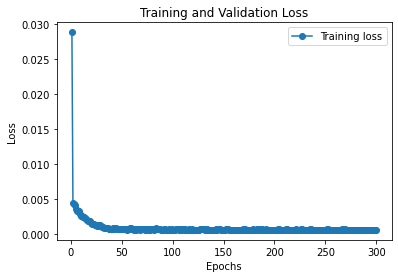

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 35ms/step - loss: 0.0838 - accuracy: 0.0019
Epoch 2/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0048 - accuracy: 0.0017
Epoch 3/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0042 - accuracy: 7.0635e-04
Epoch 4/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0039 - accuracy: 8.4321e-04
Epoch 5/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0035 - accuracy: 0.0013
Epoch 6/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0033 - accuracy: 0.0014
Epoch 7/300
47/47 [==============================] - 2s 35ms/step - loss: 0.00

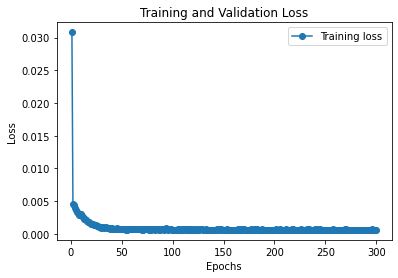

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 39ms/step - loss: 0.0659 - accuracy: 3.4670e-04
Epoch 2/300
47/47 [==============================] - 2s 40ms/step - loss: 0.0051 - accuracy: 0.0027
Epoch 3/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0043 - accuracy: 8.6105e-04
Epoch 4/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0042 - accuracy: 2.2466e-04
Epoch 5/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0033 - accuracy: 0.0014
Epoch 6/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0032 - accuracy: 4.9229e-04
Epoch 7/300
47/47 [==============================] - 2s 38ms/step - lo

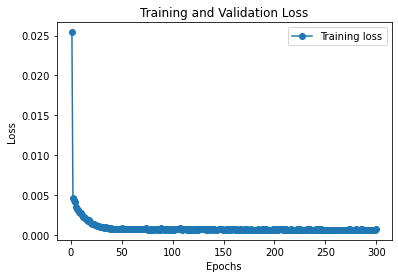

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 38ms/step - loss: 0.0637 - accuracy: 0.0013
Epoch 2/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0049 - accuracy: 0.0017
Epoch 3/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0041 - accuracy: 0.0010
Epoch 4/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0044 - accuracy: 9.6723e-04
Epoch 5/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0034 - accuracy: 0.0041
Epoch 6/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0034 - accuracy: 0.0014
Epoch 7/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0031 -

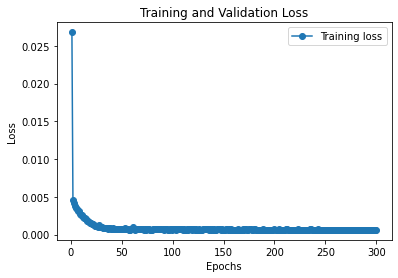

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 38ms/step - loss: 0.0749 - accuracy: 0.0017
Epoch 2/300
47/47 [==============================] - 2s 40ms/step - loss: 0.0049 - accuracy: 0.0015
Epoch 3/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0041 - accuracy: 0.0014
Epoch 4/300
47/47 [==============================] - 2s 39ms/step - loss: 0.0041 - accuracy: 0.0030
Epoch 5/300
47/47 [==============================] - 2s 39ms/step - loss: 0.0037 - accuracy: 5.0981e-04
Epoch 6/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0033 - accuracy: 8.1449e-04
Epoch 7/300
47/47 [==============================] - 2s 39ms/step - loss: 0.00

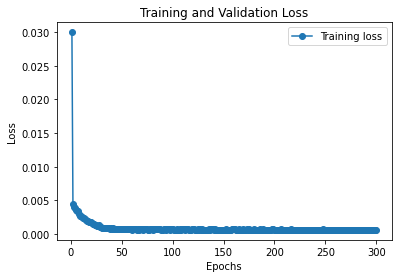

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 5s 35ms/step - loss: 0.0834 - accuracy: 0.0024
Epoch 2/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0048 - accuracy: 7.4065e-04
Epoch 3/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0041 - accuracy: 0.0014
Epoch 4/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0039 - accuracy: 7.8894e-04
Epoch 5/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0039 - accuracy: 0.0023
Epoch 6/300
47/47 [==============================] - 2s 35ms/step - loss: 0.0035 - accuracy: 0.0013
Epoch 7/300
47/47 [==============================] - 2s 36ms/step - loss: 0.00

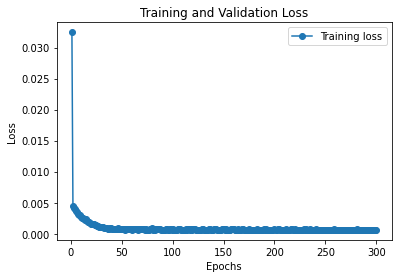

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 36ms/step - loss: 0.0715 - accuracy: 0.0021
Epoch 2/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0045 - accuracy: 5.0401e-04
Epoch 3/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0042 - accuracy: 8.1156e-04
Epoch 4/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0041 - accuracy: 3.8072e-04
Epoch 5/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0037 - accuracy: 0.0010
Epoch 6/300
47/47 [==============================] - 2s 36ms/step - loss: 0.0034 - accuracy: 2.2218e-04
Epoch 7/300
47/47 [==============================] - 2s 37ms/step - lo

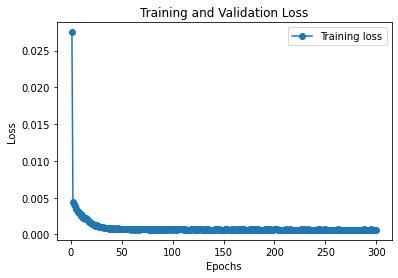

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 38ms/step - loss: 0.0750 - accuracy: 3.7304e-04
Epoch 2/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0044 - accuracy: 0.0023
Epoch 3/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0041 - accuracy: 0.0032
Epoch 4/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0044 - accuracy: 0.0015
Epoch 5/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0037 - accuracy: 0.0025
Epoch 6/300
47/47 [==============================] - 2s 38ms/step - loss: 0.0033 - accuracy: 7.9165e-04
Epoch 7/300
47/47 [==============================] - 2s 37ms/step - loss: 0.00

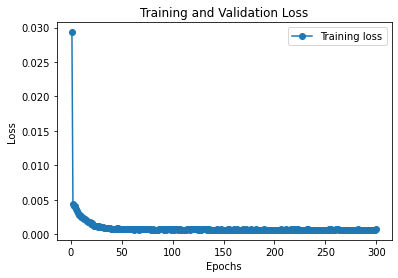

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****

[*********************100%***********************]  1 of 1 completed
 ***** get data finished *****
 
 ***** prep data finished ***** 

Epoch 1/300
47/47 [==============================] - 6s 36ms/step - loss: 0.0697 - accuracy: 8.8896e-04
Epoch 2/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0047 - accuracy: 6.2260e-04
Epoch 3/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0043 - accuracy: 4.8796e-04
Epoch 4/300
47/47 [==============================] - 2s 37ms/step - loss: 0.0038 - accuracy: 0.0014
Epoch 5/300
47/47 [==============================] - 2s 39ms/step - loss: 0.0036 - accuracy: 3.8913e-04
Epoch 6/300
47/47 [==============================] - 2s 41ms/step - loss: 0.0037 - accuracy: 0.0033
Epoch 7/300
47/47 [==============================] - 2s 37ms/step - lo

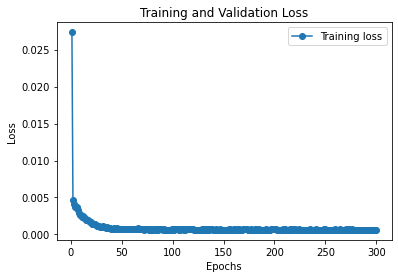

 ***** display loss finished *****

 ***** get quote finished *****

 ***** get quote prep finished *****

 ***** get results finished *****

 ***** append table finished *****



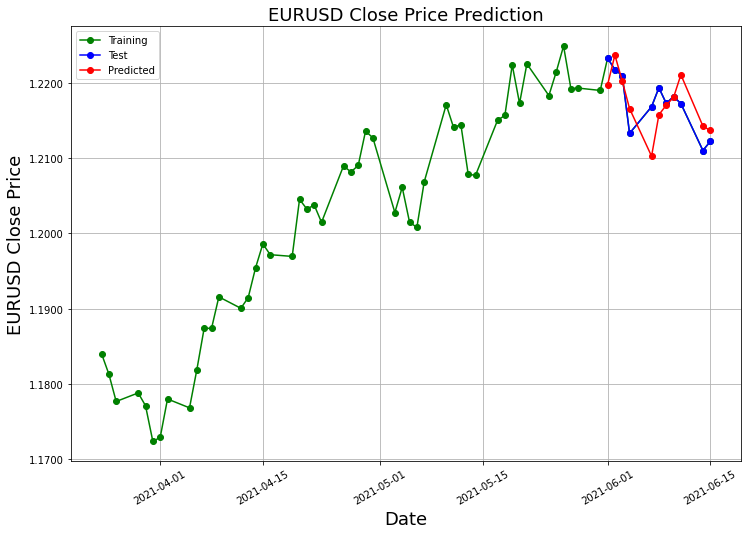

 ***** display graph finished *****

         Date  Predictions  Close_previous_day action     Close      pips
0  2021-06-01     1.219751            1.219007    buy  1.223287  0.004280
1  2021-06-02     1.223698            1.223287    buy  1.221777 -0.001510
2  2021-06-03     1.220270            1.221777   sale  1.220986  0.000791
3  2021-06-04     1.216595            1.220986   sale  1.213301  0.007686
4  2021-06-07     1.210268            1.213301   sale  1.216841 -0.003540
5  2021-06-08     1.215771            1.216841   sale  1.219363 -0.002522
6  2021-06-09     1.217049            1.219363   sale  1.217285  0.002078
7  2021-06-10     1.218089            1.217285    buy  1.218200  0.000915
8  2021-06-11     1.221091            1.218200    buy  1.217256 -0.000945
9  2021-06-14     1.214271            1.217256   sale  1.211020  0.006235
10 2021-06-15     1.213682            1.211020    buy  1.212224  0.001204


'\n\n\n\nresults()\ndisplay()'

In [370]:
import matplotlib.ticker as ticker

days_to_display=60
window_size=30  ## number of time steps to look back
units_n = 50
epochs_n = 300  #set
bs_n = 32  #set
seq = 20

# initialize a dataframe
df_result_table = pd.DataFrame(columns=["Date", "Predictions", "Close_previous_day", "action", "Close", "pips"]) 


for date in list_of_dates_to_analyze:
    #print(date)
    data_new1 = get_data(date)
    #print(data_new1)
    X_train_new1, y_train_new1, test_new, sc_new = prep_data(data_new1, window_size)
    
    # run model
    tf.random.set_seed(123)    
    model_new = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model_new.add(LSTM(units = units_n, return_sequences = True, input_shape = (X_train_new1.shape[1], 1)))
    # Adding a second LSTM layer and some Dropout regularisation
    model_new.add(LSTM(units = units_n, return_sequences = True))
    model_new.add(LSTM(units = units_n, return_sequences = False))
    # Adding the output layer
    model_new.add(Dense(units = 1))
    # Compiling the RNN
    model_new.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])
    # Fitting the RNN to the Training set
    history_new = model_new.fit(X_train_new1, y_train_new1, epochs = epochs_n, batch_size = bs_n)
    
    # display loss
    display_loss(history_new)
    
    # get quotes for the test dataset
    X_test_new = get_quote(data_new1, sc_new, window_size)
    
    # Make Predictions using the test set
    predicted_stock_price_new = model_new.predict(X_test_new)
    predicted_stock_price_new = sc_new.inverse_transform(predicted_stock_price_new)
    predicted_stock_price_new 

    # prepare data
    plot_train_new1, plot_valid_new1 = get_quote_prep(data_new1,predicted_stock_price_new)

    # get the results
    data_result1 = get_results(plot_train_new1, plot_valid_new1)

    # append the results
    df_result_table = df_result_table.append(append_result(data_result1), ignore_index=True)
    

display_graph(data_new1, df_result_table, days_to_display)
print(df_result_table)



In [371]:
df_result_table

,Date,Predictions,Close_previous_day,action,Close,pips
0,2021-06-01,1.219751,1.219007,buy,1.223287,0.004280
1,2021-06-02,1.223698,1.223287,buy,1.221777,-0.001510
2,2021-06-03,1.220270,1.221777,sale,1.220986,0.000791
3,2021-06-04,1.216595,1.220986,sale,1.213301,0.007686
4,2021-06-07,1.210268,1.213301,sale,1.216841,-0.003540
5,2021-06-08,1.215771,1.216841,sale,1.219363,-0.002522
6,2021-06-09,1.217049,1.219363,sale,1.217285,0.002078
7,2021-06-10,1.218089,1.217285,buy,1.218200,0.000915
8,2021-06-11,1.221091,1.218200,buy,1.217256,-0.000945
9,2021-06-14,1.214271,1.217256,sale,1.211020,0.006235


In [414]:
df_result_table.groupby('action').sum().pips

action
buy     0.003944
sale    0.010727
Name: pips, dtype: float64

In [415]:
accuracy_new=df_result_table.pips[df_result_table.pips>0].count()/len(df_result_table.pips)
accuracy_new*100

63.63636363636363

In [417]:
#GET THE ROOT MEAN SQUARED
rmse_new=np.sqrt(np.mean((df_result_table.Predictions - df_result_table.Close)**2))
rmse_new

0.003178565420134248

# Combined display of results

In [422]:
def display_graph2(plot_train_new1, plot_valid_B, plot_valid_A, days_to_display):
    plt.figure(figsize=(12,8))
    plt.plot(plot_train_new1.Date[-days_to_display:],plot_train_new1.Close[-days_to_display:], color = 'green', label = 'Training', marker='o')
    plt.plot(plot_valid_A.Date, plot_valid_B.Close, color = 'blue', label = 'Test', marker='o')
    plt.plot(plot_valid_A.Date, plot_valid_B.Predictions, color = 'red', label = 'Predicted B', marker='o')
    plt.plot(plot_valid_A.Date, plot_valid_A.Predictions, color = 'orange', label = 'Predicted A', marker='o')
    plt.title('EURUSD Close Price Prediction', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('EURUSD Close Price', fontsize=18)


    plt.xticks(rotation=30)
    ax=plt.gca()
    formatter = ticker.FormatStrFormatter('%1.4f')
    ax.yaxis.set_major_formatter(formatter)

    plt.legend()
    plt.grid(True)
    plt.show()
    print(' ***** display graph finished *****\n')

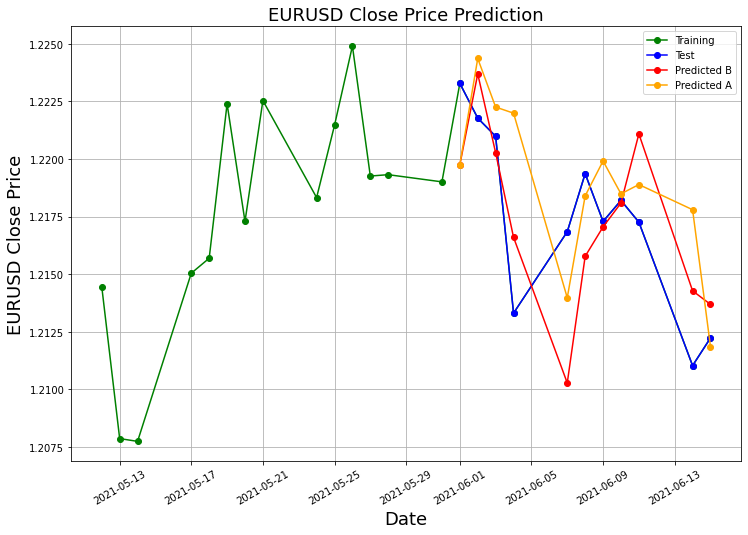

 ***** display graph finished *****



In [428]:
days_to_display2=25
display_graph2(data_new1, df_result_table, data1.reset_index(), days_to_display2)

In [419]:
data_new1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,1.106305,1.122000,1.105620,1.106305,1.106305,0
1,2015-07-13,1.112904,1.119759,1.100770,1.112904,1.112904,0
2,2015-07-14,1.098515,1.107400,1.096850,1.099046,1.099046,0
3,2015-07-15,1.100897,1.104000,1.093610,1.100800,1.100800,0
4,2015-07-16,1.093888,1.095000,1.085940,1.094355,1.094355,0
...,...,...,...,...,...,...,...
1520,2021-06-09,1.217182,1.221899,1.217182,1.217285,1.217285,0
1521,2021-06-10,1.217730,1.219215,1.214535,1.218200,1.218200,0
1522,2021-06-11,1.217315,1.219500,1.209500,1.217256,1.217256,0
1523,2021-06-14,1.211079,1.213151,1.209526,1.211020,1.211020,0


In [421]:
data1

,Date,Close,Predictions,action,Close_previous_day,pips
0,2021-06-01,1.223287,1.219751,buy,1.219007,0.004280
1,2021-06-02,1.221777,1.224368,buy,1.223287,-0.001510
2,2021-06-03,1.220986,1.222257,sale,1.221777,0.000791
3,2021-06-04,1.213301,1.221992,sale,1.220986,0.007686
4,2021-06-07,1.216841,1.213970,sale,1.213301,-0.003540
5,2021-06-08,1.219363,1.218397,buy,1.216841,0.002522
6,2021-06-09,1.217285,1.219913,buy,1.219363,-0.002078
7,2021-06-10,1.218200,1.218486,sale,1.217285,-0.000915
8,2021-06-11,1.217256,1.218890,buy,1.218200,-0.000945
9,2021-06-14,1.211020,1.217797,sale,1.217256,0.006235
